# Libraries

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from functools import partial

# modeling
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Get dataset

In [9]:
# providers_lucas = pd.read_csv("./data/providers.csv", low_memory=False).fillna(0)
# providers_ryan = pd.read_csv("./data/Ryan_providers.csv", low_memory=False)
providers = pd.read_csv("./data/Providers_Final.csv", low_memory=False)

# providers = providers_lucas.join(providers_ryan.set_index('Provider'), on='Provider')

In [11]:
providers = providers.fillna(0)
providers

,Unnamed: 0,Provider,PotentialFraud,Perc_Outpatient,HasTop5AdmtCode,PatientsPerAttPhys,PatientsPerOperPhys,PatientsPerOthPhys,Perc_MultHospAttPhys,Perc_ClaimsPerTopFraudState,Perc_DualPatientProvider,Perc_DualPatientType,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,Ratio_ClaimsPerAttPhys,Ratio_ClaimsPerPatient,IP_AnnualDeductibleAmt,IP_AnnualReimbursementAmt,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AdmitDuration,IP_Mean_ClaimCost,IP_Mean_ClaimDuration,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_SumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_Dup,IP_Perc_GenderZero,IP_Perc_HasAllPhys,IP_Perc_HasDied,IP_Perc_HasNoPhys,IP_Perc_HasRenalDisease,IP_Perc_HeartFailure_Chronic,IP_Perc_InsReimbursementRatio,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_Mean_AgeAtClaim,IP_Perc_Mean_NumConds,IP_Perc_MultHosp,IP_Perc_No_ProcCode,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RaceOne,IP_Perc_RaceThree,IP_Perc_RaceTwo,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,OP_AnnualDeductibleAmt,OP_AnnualReimbursementAmt,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_ClaimCost,OP_Mean_ClaimDuration,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_SumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_Dup,OP_Perc_GenderZero,OP_Perc_HasAllPhys,OP_Perc_HasDied,OP_Perc_HasNoPhys,OP_Perc_HasRenalDisease,OP_Perc_HeartFailure_Chronic,OP_Perc_InsReimbursementRatio,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_Mean_AgeAtClaim,OP_Perc_Mean_NumConds,OP_Perc_MultHosp,OP_Perc_No_DiagCode,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RaceOne,OP_Perc_RaceThree,OP_Perc_RaceTwo,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic
0,0,PRV51001,0.350000,0.300000,77.950000,0.000000,5.450000,1.000000,0.800000,0.200000,0.000000,0.650000,0.750000,0.650000,0.200000,0.400000,0.250000,0.850000,0.950000,0.300000,0.250000,0.200000,0.050000,0.000000,382.000000,0.000000,382.000000,307.000000,12.000000,12.000000,1.550000,0.400000,0.400000,77.600000,0.000000,6.000000,0.878279,1.000000,0.000000,0.0,0.400000,0.800000,0.800000,0.200000,0.400000,0.800000,0.800000,0.800000,0.000000,0.600000,0.400000,0.2,0.0,19400.000000,1068.0,20468.000000,4077.360000,12.000000,12.000000,6.000000,6.000000,17606.000000,897.120000,2615.200000,463.920000,0,10,19,16,1.041667,1.785714,0.800000,5.0,1.0,19.0,1.0,6.000000,5.450000,0.240000,0.040000,0.000000,0.160000,0.920000,1.0,0.000000,0.550000,0.000000,0.600000,0.0,0.040000,0.040000
1,1,PRV51003,0.471429,0.171429,68.371429,0.000000,4.214286,0.994032,0.828571,0.157143,0.000000,0.342857,0.628571,0.357143,0.042857,0.257143,0.414286,0.728571,0.814286,0.285714,0.271429,0.071429,0.057143,0.000000,466.714286,1.000000,467.714286,336.440760,11.828571,11.928571,3.357143,0.338710,0.274194,69.935484,0.016129,4.919355,0.821059,0.790323,0.209677,0.0,0.516129,0.580645,0.629032,0.112903,0.370968,0.403226,0.790323,0.887097,0.209677,0.306452,0.112903,0.0,0.0,9241.935484,1068.0,10309.935484,2384.941628,11.806452,11.806452,6.161290,6.161290,7568.181818,931.424242,2678.181818,737.121212,1,73,110,95,1.128205,3.000000,0.530303,53.0,3.0,66.0,3.0,4.919355,4.214286,0.007576,0.000000,0.000000,0.045455,0.818182,1.0,0.016129,0.357143,0.000000,0.370968,0.0,0.060606,0.060606
2,2,PRV51004,0.308725,0.154362,71.302013,0.006711,4.342282,0.978485,0.000000,0.000000,0.000000,0.429530,0.590604,0.335570,0.107383,0.275168,0.422819,0.704698,0.724832,0.328859,0.308725,0.114094,0.080537,0.000000,350.134228,2.080537,352.214765,250.363050,11.865772,11.959732,2.429530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0

In [12]:
scores = providers.drop(['PotentialFraud','Unnamed: 0','Provider'], axis=1)
scores_cols = scores.columns
scores = preprocessing.normalize(scores, norm='l1')
scores_norm = pd.DataFrame(scores, columns = scores_cols)

providers['PotentialFraud'] = np.where(providers['PotentialFraud'] >= 0.5, 1, 0)
decision = providers["PotentialFraud"]

Xtrain, Xtest, ytrain, ytest = train_test_split(scores, decision, random_state=0)

# Modeling

### train a simple classifier model and handling imbalanced classes

In [14]:
logistic_regression = LogisticRegression(random_state=0, class_weight="balanced")
logreg = logistic_regression.fit(Xtrain, ytrain)

print("Training set score: {:.3f}".format(logreg.score(Xtrain, ytrain))) 
print("Test set score: {:.3f}".format(logreg.score(Xtest, ytest)))

Training set score: 0.552
Test set score: 0.553


In [15]:
logreg100 = LogisticRegression(C=100).fit(Xtrain, ytrain)
print("Training set score: {:.3f}".format(logreg100.score(Xtrain, ytrain))) 
print("Test set score: {:.3f}".format(logreg100.score(Xtest, ytest)))

Training set score: 0.765
Test set score: 0.768


In [25]:
param_grid = [{'C': np.logspace(-1,1,100)}]
logreg100cv = GridSearchCV(logreg100, param_grid = param_grid).fit(Xtrain,ytrain)

### decision tree

In [28]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0) 
tree.fit(Xtrain, ytrain)
print("Accuracy on training set: {:.3f}".format(tree.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.3f}".format(tree.score(Xtest, ytest)))

Accuracy on training set: 0.770
Accuracy on test set: 0.765


In [29]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01020482
 0.01831829 0.         0.         0.         0.         0.01475145
 0.         0.02368866 0.         0.11452734 0.         0.
 0.08282154 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01721216
 0.04494518 0.         0.         0.         0.18686314 0.
 0.         0.         0.         0.         0.         0.12079699
 0.         0.         0.         0.         0.         0.
 0.36587043 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


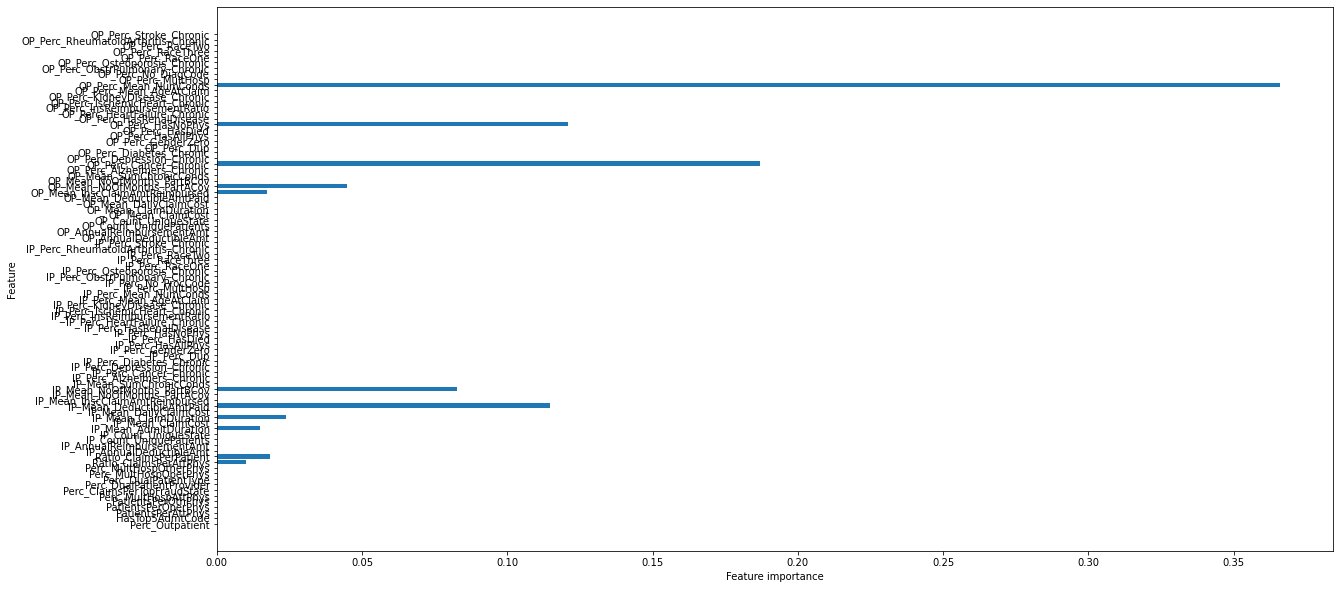

In [50]:
def plot_feature_importances(model):
    n_features = scores.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), scores_cols.to_numpy()) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


plt.figure(figsize=(20,10))
plot_feature_importances(tree)

### random forest

In [52]:
forest = RandomForestClassifier(n_estimators=100, random_state=0) 
forest.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.3f}".format(forest.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.3f}".format(forest.score(Xtest, ytest)))

Accuracy on training set: 1.000
Accuracy on test set: 0.765


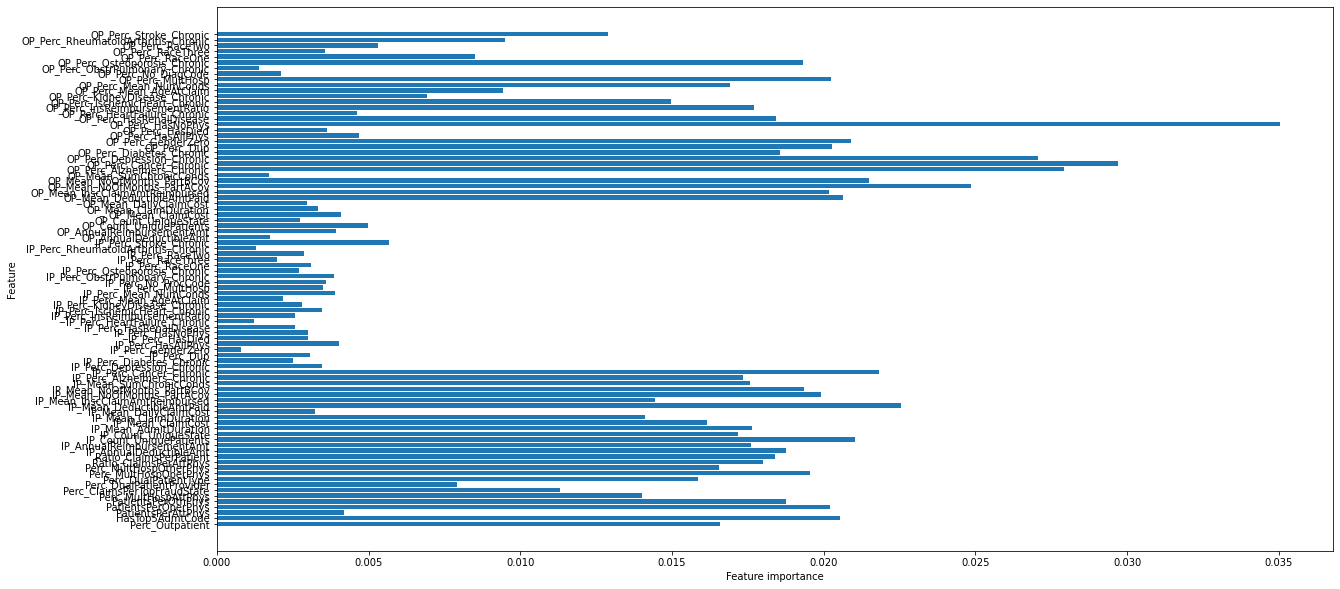

In [55]:
plt.figure(figsize=(20,10))
plot_feature_importances(forest)

### gradient boosting

In [58]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.826
Accuracy on test set: 0.761


In [60]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) 
gbrt.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.771
Accuracy on test set: 0.769


In [61]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01) 
gbrt.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.764
Accuracy on test set: 0.766


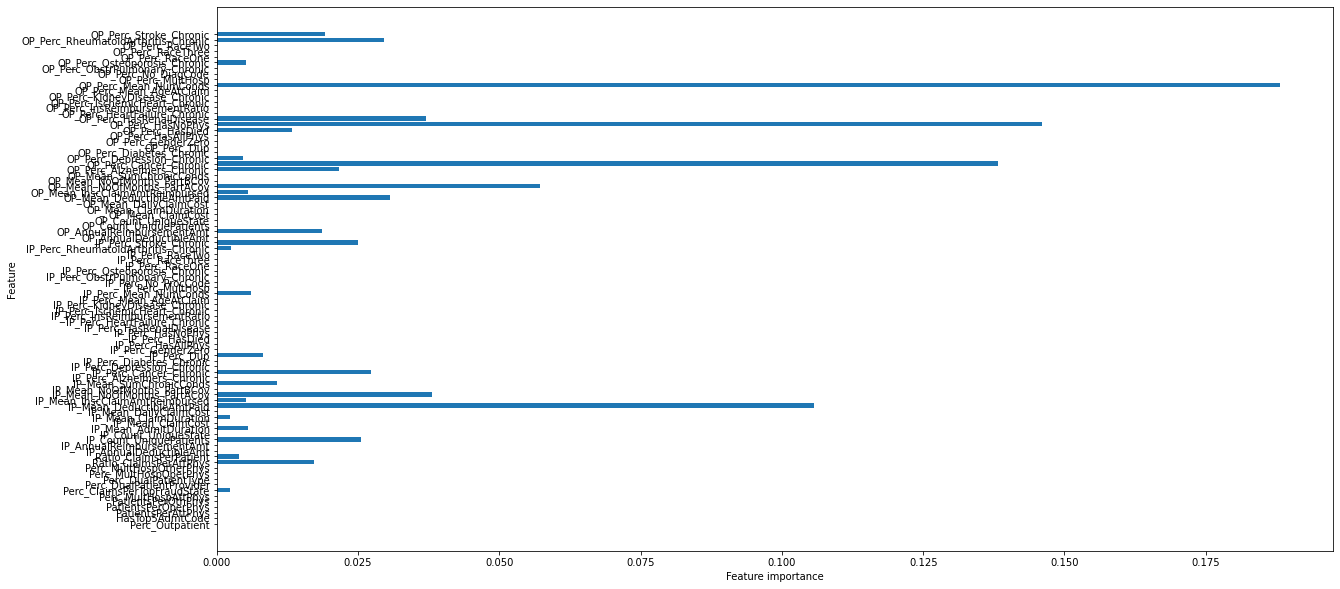

In [63]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1) 
gbrt.fit(Xtrain, ytrain)

plt.figure(figsize=(20,10))
plot_feature_importances(gbrt)

### support vector machine

In [67]:
svc = SVC() 
svc.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.2f}".format(svc.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.2f}".format(svc.score(Xtest, ytest)))

Accuracy on training set: 0.76
Accuracy on test set: 0.77


In [68]:
svc = SVC(C=1000) 
svc.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.2f}".format(svc.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.2f}".format(svc.score(Xtest, ytest)))

Accuracy on training set: 0.76
Accuracy on test set: 0.77
